## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 7 slices in the middle
* slide inference

In [1]:
idxs = range(65)
idxs

range(0, 65)

In [2]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [3]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [4]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [5]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [6]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [7]:
import segmentation_models_pytorch as smp

In [8]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [9]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp014'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 7 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [12]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [13]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [14]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [15]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    # mid = 65 // 2
    # start = mid - CFG.in_chans // 2
    # end = mid + CFG.in_chans // 2
    # idxs = range(start, end)
    idxs = [15,16,31,32,33,48,49]

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [16]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [17]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [19]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [20]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [21]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [22]:
train_dataset[0][0].shape

torch.Size([7, 224, 224])

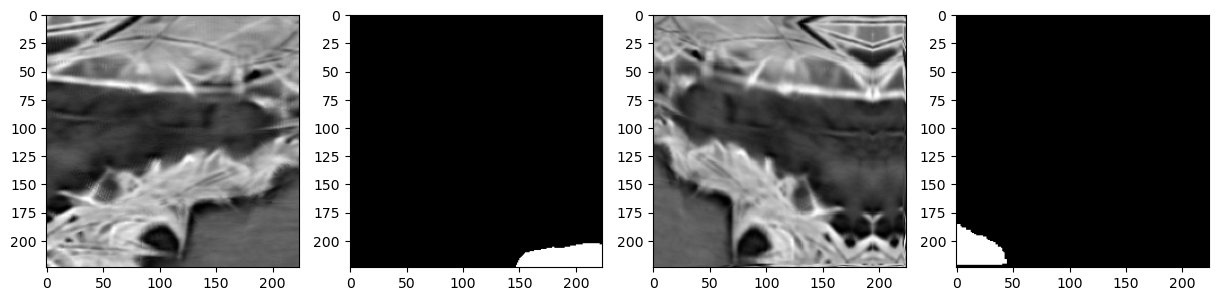

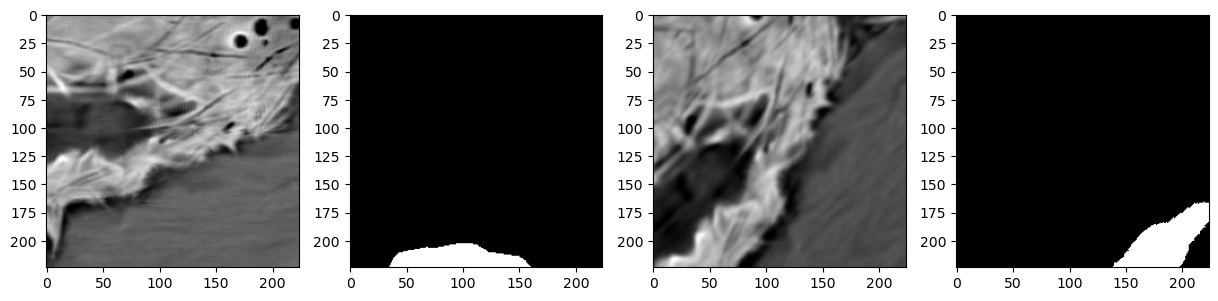

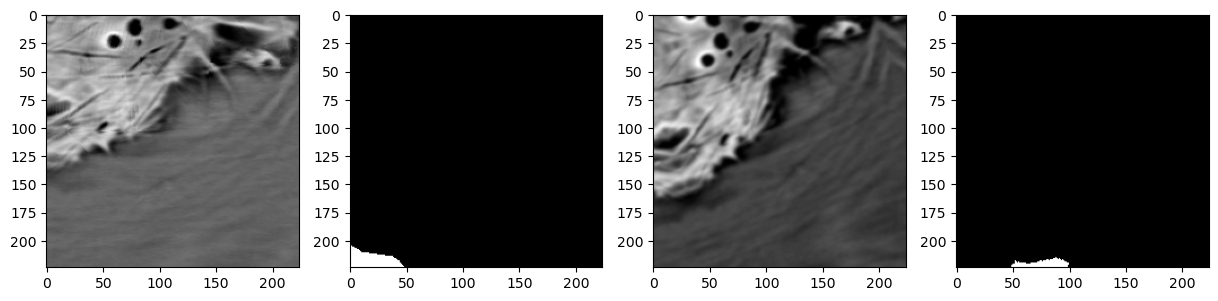

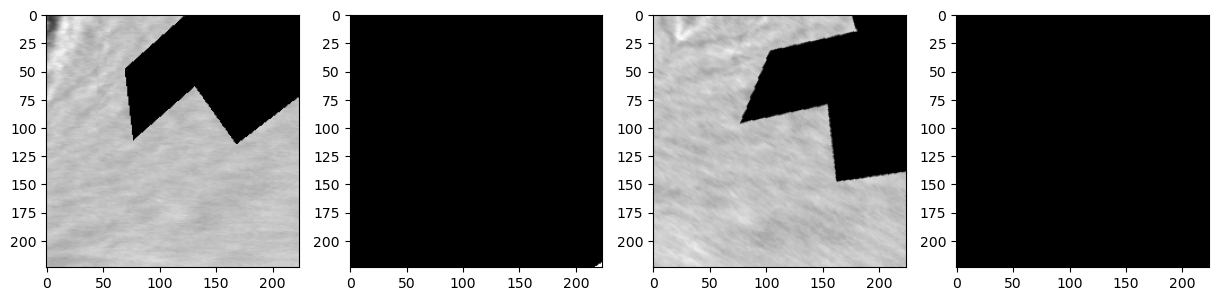

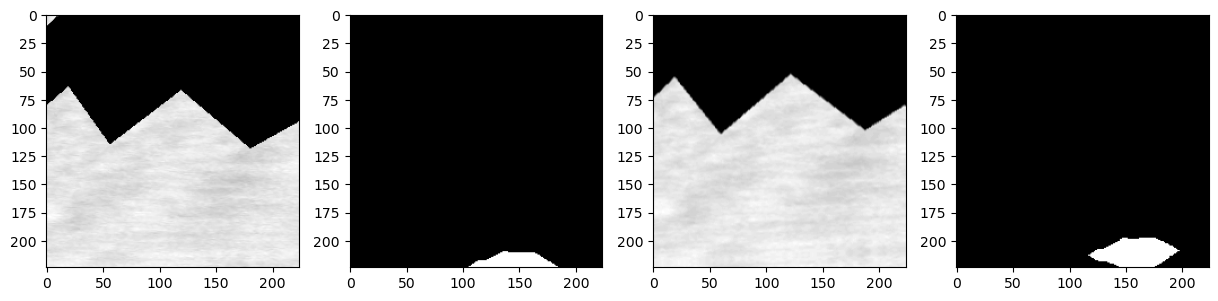

In [23]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [24]:
del plot_dataset
gc.collect()

48110

## model

In [25]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [26]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [27]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [28]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [29]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [30]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [31]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [32]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [33]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [34]:
＠ふ０ｎ
fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.20932576988122237
th: 0.15, fbeta: 0.22885660444070935
th: 0.2, fbeta: 0.23896344245964093
th: 0.25, fbeta: 0.24858538388388698
th: 0.3, fbeta: 0.2613741901809701
th: 0.35, fbeta: 0.26834364103004327
th: 0.4, fbeta: 0.2054110383422871
th: 0.45, fbeta: 0.05766439159047923


best_th: 0.35, fbeta: 0.26834364103004327
Epoch 1 - avg_train_loss: 0.4030  avg_val_loss: 0.3142  time: 227s
Epoch 1 - avgScore: 0.2683
Epoch 1 - Save Best Score: 0.2683 Model
Epoch 1 - Save Best Loss: 0.3142 Model


th: 0.5, fbeta: 0.0060588884501422


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23231532941999403
th: 0.15, fbeta: 0.24925298887168068
th: 0.2, fbeta: 0.26930783701143607
th: 0.25, fbeta: 0.30145523818874687
th: 0.3, fbeta: 0.34539940673858993
th: 0.35, fbeta: 0.3655829071146415
th: 0.4, fbeta: 0.2932459433469214
th: 0.45, fbeta: 0.07388496293214243


best_th: 0.35, fbeta: 0.3655829071146415
Epoch 2 - avg_train_loss: 0.3169  avg_val_loss: 0.2784  time: 230s
Epoch 2 - avgScore: 0.3656
Epoch 2 - Save Best Score: 0.3656 Model
Epoch 2 - Save Best Loss: 0.2784 Model


th: 0.5, fbeta: 0.0013167038211927453


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.24325682398888074
th: 0.15, fbeta: 0.2588470310371807
th: 0.2, fbeta: 0.27594658858333115
th: 0.25, fbeta: 0.29236339630977126
th: 0.3, fbeta: 0.3076122056058924
th: 0.35, fbeta: 0.31778569584335137
th: 0.4, fbeta: 0.30680742430247515
th: 0.45, fbeta: 0.01851281335365983


best_th: 0.35, fbeta: 0.31778569584335137
Epoch 3 - avg_train_loss: 0.2801  avg_val_loss: 0.2662  time: 229s
Epoch 3 - avgScore: 0.3178


th: 0.5, fbeta: 7.490710713608432e-06


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27644999834160666
th: 0.15, fbeta: 0.3041551282448104
th: 0.2, fbeta: 0.3251427304725867
th: 0.25, fbeta: 0.33778421826123767
th: 0.3, fbeta: 0.3490681339668473
th: 0.35, fbeta: 0.3595849105351068
th: 0.4, fbeta: 0.36347998722312946
th: 0.45, fbeta: 0.34965221405520247


best_th: 0.4, fbeta: 0.36347998722312946
Epoch 4 - avg_train_loss: 0.2603  avg_val_loss: 0.2533  time: 229s
Epoch 4 - avgScore: 0.3635


th: 0.5, fbeta: 0.31792683932166843


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26638091875746217
th: 0.15, fbeta: 0.2882184963169312
th: 0.2, fbeta: 0.31069252536268865
th: 0.25, fbeta: 0.3375601069844051
th: 0.3, fbeta: 0.3580559210225068
th: 0.35, fbeta: 0.37511376430774684
th: 0.4, fbeta: 0.38910987641442857
th: 0.45, fbeta: 0.4008756239455683


best_th: 0.5, fbeta: 0.40852811195981725
Epoch 5 - avg_train_loss: 0.2502  avg_val_loss: 0.2583  time: 230s
Epoch 5 - avgScore: 0.4085
Epoch 5 - Save Best Score: 0.4085 Model
Epoch 5 - Save Best Loss: 0.2583 Model


th: 0.5, fbeta: 0.40852811195981725


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33052323417867624
th: 0.15, fbeta: 0.3885011769304483
th: 0.2, fbeta: 0.4265644555490921
th: 0.25, fbeta: 0.4421145952160597
th: 0.3, fbeta: 0.4499540017986289
th: 0.35, fbeta: 0.4516861669477714
th: 0.4, fbeta: 0.44034018678882797
th: 0.45, fbeta: 0.4236347399625701


best_th: 0.35, fbeta: 0.4516861669477714
Epoch 6 - avg_train_loss: 0.2394  avg_val_loss: 0.2517  time: 229s
Epoch 6 - avgScore: 0.4517
Epoch 6 - Save Best Score: 0.4517 Model
Epoch 6 - Save Best Loss: 0.2517 Model


th: 0.5, fbeta: 0.40319393563822425


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31695733232529366
th: 0.15, fbeta: 0.34145056623434583
th: 0.2, fbeta: 0.35973517297862584
th: 0.25, fbeta: 0.3708302401370197
th: 0.3, fbeta: 0.37661523647740963
th: 0.35, fbeta: 0.3765928541368151
th: 0.4, fbeta: 0.37267537000907613
th: 0.45, fbeta: 0.3650534940896718


best_th: 0.3, fbeta: 0.37661523647740963
Epoch 7 - avg_train_loss: 0.2307  avg_val_loss: 0.2837  time: 230s
Epoch 7 - avgScore: 0.3766


th: 0.5, fbeta: 0.3493676038701877


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33459133143483627
th: 0.15, fbeta: 0.3602572993444792
th: 0.2, fbeta: 0.372248989432529
th: 0.25, fbeta: 0.3808164328297792
th: 0.3, fbeta: 0.3852647460118969
th: 0.35, fbeta: 0.37994406020642574
th: 0.4, fbeta: 0.3664386025901219
th: 0.45, fbeta: 0.3476726061228101


best_th: 0.3, fbeta: 0.3852647460118969
Epoch 8 - avg_train_loss: 0.2163  avg_val_loss: 0.2779  time: 230s
Epoch 8 - avgScore: 0.3853


th: 0.5, fbeta: 0.32566125867496687


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3810759802240203
th: 0.15, fbeta: 0.3979870490856318
th: 0.2, fbeta: 0.4063739886453919
th: 0.25, fbeta: 0.41302971567456415
th: 0.3, fbeta: 0.4175851462918101
th: 0.35, fbeta: 0.4127061542026449
th: 0.4, fbeta: 0.4003168894017417
th: 0.45, fbeta: 0.3732031077336752


best_th: 0.3, fbeta: 0.4175851462918101
Epoch 9 - avg_train_loss: 0.2028  avg_val_loss: 0.3192  time: 229s
Epoch 9 - avgScore: 0.4176


th: 0.5, fbeta: 0.33778604291772085


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31997707167803624
th: 0.15, fbeta: 0.33653119144939436
th: 0.2, fbeta: 0.3468959840399777
th: 0.25, fbeta: 0.35622061785679876
th: 0.3, fbeta: 0.36522893304560133
th: 0.35, fbeta: 0.3769753067993224
th: 0.4, fbeta: 0.3836977767667733
th: 0.45, fbeta: 0.38664014064950925


best_th: 0.45, fbeta: 0.38664014064950925
Epoch 10 - avg_train_loss: 0.1951  avg_val_loss: 0.2961  time: 231s
Epoch 10 - avgScore: 0.3866


th: 0.5, fbeta: 0.37962813100934883


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31650630334948626
th: 0.15, fbeta: 0.3340464496035367
th: 0.2, fbeta: 0.34929574530699603
th: 0.25, fbeta: 0.3621802574777893
th: 0.3, fbeta: 0.37176190812646376
th: 0.35, fbeta: 0.374231922412097
th: 0.4, fbeta: 0.37425131031727416
th: 0.45, fbeta: 0.3708907131717617


best_th: 0.4, fbeta: 0.37425131031727416
Epoch 11 - avg_train_loss: 0.1826  avg_val_loss: 0.3096  time: 229s
Epoch 11 - avgScore: 0.3743


th: 0.5, fbeta: 0.3653886404455789


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3347378032015634
th: 0.15, fbeta: 0.34784777004568596
th: 0.2, fbeta: 0.3548500956014146
th: 0.25, fbeta: 0.3579083991774786
th: 0.3, fbeta: 0.36196153446979523
th: 0.35, fbeta: 0.3652642133593733
th: 0.4, fbeta: 0.36876183259982553
th: 0.45, fbeta: 0.3647650683117217


best_th: 0.4, fbeta: 0.36876183259982553
Epoch 12 - avg_train_loss: 0.1723  avg_val_loss: 0.3351  time: 229s
Epoch 12 - avgScore: 0.3688


th: 0.5, fbeta: 0.3568457599332081


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37325053416988985
th: 0.15, fbeta: 0.3939509646781287
th: 0.2, fbeta: 0.41136550088707263
th: 0.25, fbeta: 0.42202475166719117
th: 0.3, fbeta: 0.4304709726726821
th: 0.35, fbeta: 0.43617572596448945
th: 0.4, fbeta: 0.43159791209553294
th: 0.45, fbeta: 0.42283199527922843


best_th: 0.35, fbeta: 0.43617572596448945
Epoch 13 - avg_train_loss: 0.1602  avg_val_loss: 0.3344  time: 230s
Epoch 13 - avgScore: 0.4362


th: 0.5, fbeta: 0.406365991480803


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.351367228283968
th: 0.15, fbeta: 0.37467693836947613
th: 0.2, fbeta: 0.3896098180987841
th: 0.25, fbeta: 0.39963839356330366
th: 0.3, fbeta: 0.4075744626476264
th: 0.35, fbeta: 0.41553590962452147
th: 0.4, fbeta: 0.4137608100584015
th: 0.45, fbeta: 0.4044547407713252


best_th: 0.35, fbeta: 0.41553590962452147
Epoch 14 - avg_train_loss: 0.1495  avg_val_loss: 0.3194  time: 230s
Epoch 14 - avgScore: 0.4155


th: 0.5, fbeta: 0.39235684562492545


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32478802333437506
th: 0.15, fbeta: 0.3368667245004946
th: 0.2, fbeta: 0.34616301563000623
th: 0.25, fbeta: 0.3514646066505281
th: 0.3, fbeta: 0.3516690152384551
th: 0.35, fbeta: 0.3506752519973779
th: 0.4, fbeta: 0.34931824397298966
th: 0.45, fbeta: 0.34545747307356606


best_th: 0.3, fbeta: 0.3516690152384551
Epoch 15 - avg_train_loss: 0.1411  avg_val_loss: 0.3556  time: 229s
Epoch 15 - avgScore: 0.3517


th: 0.5, fbeta: 0.3389767351519628


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33573965002435285
th: 0.15, fbeta: 0.3599655836739586
th: 0.2, fbeta: 0.37746386940952464
th: 0.25, fbeta: 0.39188845966057956
th: 0.3, fbeta: 0.4009278869926486
th: 0.35, fbeta: 0.40657408799135253
th: 0.4, fbeta: 0.41011436611518476
th: 0.45, fbeta: 0.40588530745859763


best_th: 0.4, fbeta: 0.41011436611518476
Epoch 16 - avg_train_loss: 0.1342  avg_val_loss: 0.3206  time: 230s
Epoch 16 - avgScore: 0.4101


th: 0.5, fbeta: 0.3960986741998986


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3578008485120639
th: 0.15, fbeta: 0.374078570553352
th: 0.2, fbeta: 0.38097666135025604
th: 0.25, fbeta: 0.386599446328119
th: 0.3, fbeta: 0.3888550891296681
th: 0.35, fbeta: 0.3845462296649634
th: 0.4, fbeta: 0.3776848844862139
th: 0.45, fbeta: 0.3683339565002769


best_th: 0.3, fbeta: 0.3888550891296681
Epoch 17 - avg_train_loss: 0.1266  avg_val_loss: 0.3652  time: 228s
Epoch 17 - avgScore: 0.3889


th: 0.5, fbeta: 0.3546425913796774


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34198497218153495
th: 0.15, fbeta: 0.35639048209102425
th: 0.2, fbeta: 0.36460237040059373
th: 0.25, fbeta: 0.37120748210096977
th: 0.3, fbeta: 0.37640939741014423
th: 0.35, fbeta: 0.38051162428395924
th: 0.4, fbeta: 0.3837833829986265
th: 0.45, fbeta: 0.3867230122153129


best_th: 0.45, fbeta: 0.3867230122153129
Epoch 18 - avg_train_loss: 0.1184  avg_val_loss: 0.3644  time: 231s
Epoch 18 - avgScore: 0.3867


th: 0.5, fbeta: 0.38467531019536605


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3560637515778775
th: 0.15, fbeta: 0.36528714363408865
th: 0.2, fbeta: 0.3714624874914562
th: 0.25, fbeta: 0.37245371183150955
th: 0.3, fbeta: 0.3744563916020996
th: 0.35, fbeta: 0.3700103048436428
th: 0.4, fbeta: 0.36143457077016355
th: 0.45, fbeta: 0.34983715337489046


best_th: 0.3, fbeta: 0.3744563916020996
Epoch 19 - avg_train_loss: 0.1111  avg_val_loss: 0.4027  time: 230s
Epoch 19 - avgScore: 0.3745


th: 0.5, fbeta: 0.3369262105522241


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3296480685612507
th: 0.15, fbeta: 0.33782667902541746
th: 0.2, fbeta: 0.34215138559289904
th: 0.25, fbeta: 0.3453486875650529
th: 0.3, fbeta: 0.34634506173467566
th: 0.35, fbeta: 0.34326277576469627
th: 0.4, fbeta: 0.33781699738689047
th: 0.45, fbeta: 0.3291978145516047


best_th: 0.3, fbeta: 0.34634506173467566
Epoch 20 - avg_train_loss: 0.1053  avg_val_loss: 0.4375  time: 228s
Epoch 20 - avgScore: 0.3463


th: 0.5, fbeta: 0.3158108233268393


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35272376956711554
th: 0.15, fbeta: 0.3694907831991758
th: 0.2, fbeta: 0.3770691953578494
th: 0.25, fbeta: 0.3827406894199401
th: 0.3, fbeta: 0.3864445204360126
th: 0.35, fbeta: 0.38894366875355146
th: 0.4, fbeta: 0.39062291130073
th: 0.45, fbeta: 0.3856168504277569


best_th: 0.4, fbeta: 0.39062291130073
Epoch 21 - avg_train_loss: 0.1001  avg_val_loss: 0.3926  time: 230s
Epoch 21 - avgScore: 0.3906


th: 0.5, fbeta: 0.3746376217251834


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3549780896222955
th: 0.15, fbeta: 0.37142447267821277
th: 0.2, fbeta: 0.3824975675756783
th: 0.25, fbeta: 0.3852895546528024
th: 0.3, fbeta: 0.38152691693947444
th: 0.35, fbeta: 0.3746591566276192
th: 0.4, fbeta: 0.3651582723945327
th: 0.45, fbeta: 0.35487420552531984


best_th: 0.25, fbeta: 0.3852895546528024
Epoch 22 - avg_train_loss: 0.0955  avg_val_loss: 0.4299  time: 230s
Epoch 22 - avgScore: 0.3853


th: 0.5, fbeta: 0.3374418741454111


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3376817085469247
th: 0.15, fbeta: 0.34802677670830523
th: 0.2, fbeta: 0.3547541858431755
th: 0.25, fbeta: 0.3583200680193415
th: 0.3, fbeta: 0.35890867293050943
th: 0.35, fbeta: 0.3543116196900068
th: 0.4, fbeta: 0.34734624358896377
th: 0.45, fbeta: 0.33801900932107654


best_th: 0.3, fbeta: 0.35890867293050943
Epoch 23 - avg_train_loss: 0.0910  avg_val_loss: 0.4264  time: 228s
Epoch 23 - avgScore: 0.3589


th: 0.5, fbeta: 0.32826360988769515


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3356180767559054
th: 0.15, fbeta: 0.349185172492866
th: 0.2, fbeta: 0.35776195301504765
th: 0.25, fbeta: 0.36401549553306445
th: 0.3, fbeta: 0.3674288826000788
th: 0.35, fbeta: 0.3664691769097457
th: 0.4, fbeta: 0.35976046181560795
th: 0.45, fbeta: 0.3480055224288984


best_th: 0.3, fbeta: 0.3674288826000788
Epoch 24 - avg_train_loss: 0.0869  avg_val_loss: 0.4197  time: 232s
Epoch 24 - avgScore: 0.3674


th: 0.5, fbeta: 0.3343709260516121


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3326643420934244
th: 0.15, fbeta: 0.3470811735316111
th: 0.2, fbeta: 0.35915308711760074
th: 0.25, fbeta: 0.36605153935033985
th: 0.3, fbeta: 0.367375426623485
th: 0.35, fbeta: 0.3615290104107812
th: 0.4, fbeta: 0.3524171577928334
th: 0.45, fbeta: 0.3418262300276952


best_th: 0.3, fbeta: 0.367375426623485
Epoch 25 - avg_train_loss: 0.0842  avg_val_loss: 0.4241  time: 230s
Epoch 25 - avgScore: 0.3674


th: 0.5, fbeta: 0.32667416179193953


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34539930174340644
th: 0.15, fbeta: 0.35812256263944514
th: 0.2, fbeta: 0.36891619708517487
th: 0.25, fbeta: 0.3772853365410422
th: 0.3, fbeta: 0.3804287989651504
th: 0.35, fbeta: 0.37860223824075073
th: 0.4, fbeta: 0.3725169209829273
th: 0.45, fbeta: 0.36199211668036685


best_th: 0.3, fbeta: 0.3804287989651504
Epoch 26 - avg_train_loss: 0.0815  avg_val_loss: 0.4560  time: 228s
Epoch 26 - avgScore: 0.3804


th: 0.5, fbeta: 0.3454963765157201


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3401582510032027
th: 0.15, fbeta: 0.3518118208453338
th: 0.2, fbeta: 0.3617666616761535
th: 0.25, fbeta: 0.37269393648479937
th: 0.3, fbeta: 0.3826475379204687
th: 0.35, fbeta: 0.3892821537120752
th: 0.4, fbeta: 0.39000858359435203
th: 0.45, fbeta: 0.38515540879488686


best_th: 0.4, fbeta: 0.39000858359435203
Epoch 27 - avg_train_loss: 0.0785  avg_val_loss: 0.4367  time: 232s
Epoch 27 - avgScore: 0.3900


th: 0.5, fbeta: 0.37684118066799394


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3536831306639775
th: 0.15, fbeta: 0.3657882834718878
th: 0.2, fbeta: 0.3747320107806686
th: 0.25, fbeta: 0.37804046464429825
th: 0.3, fbeta: 0.37508917617482745
th: 0.35, fbeta: 0.36863523753226546
th: 0.4, fbeta: 0.3571794400277774
th: 0.45, fbeta: 0.346002484941188


best_th: 0.25, fbeta: 0.37804046464429825
Epoch 28 - avg_train_loss: 0.0758  avg_val_loss: 0.4692  time: 228s
Epoch 28 - avgScore: 0.3780


th: 0.5, fbeta: 0.33527191983626115


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3457917121235122
th: 0.15, fbeta: 0.3569864053088921
th: 0.2, fbeta: 0.3676183025584166
th: 0.25, fbeta: 0.3756437732557685
th: 0.3, fbeta: 0.3814411572406646
th: 0.35, fbeta: 0.38066030125350925
th: 0.4, fbeta: 0.3735969766072888
th: 0.45, fbeta: 0.3634343961754681


best_th: 0.3, fbeta: 0.3814411572406646
Epoch 29 - avg_train_loss: 0.0751  avg_val_loss: 0.4572  time: 231s
Epoch 29 - avgScore: 0.3814


th: 0.5, fbeta: 0.35126107055118355


  0%|          | 0/903 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35520218799477915
th: 0.15, fbeta: 0.36821749383833974
th: 0.2, fbeta: 0.3794262054309195
th: 0.25, fbeta: 0.3858412030956042
th: 0.3, fbeta: 0.38648791735807797
th: 0.35, fbeta: 0.37941859329207833
th: 0.4, fbeta: 0.36883601432388874
th: 0.45, fbeta: 0.3575651267566149


best_th: 0.3, fbeta: 0.38648791735807797
Epoch 30 - avg_train_loss: 0.0740  avg_val_loss: 0.4628  time: 232s
Epoch 30 - avgScore: 0.3865


th: 0.5, fbeta: 0.3455688894357852


In [35]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [36]:
mask_pred = check_point['preds']

In [37]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.33052323417867624
th: 0.15, fbeta: 0.3885011769304483
th: 0.2, fbeta: 0.4265644555490921
th: 0.25, fbeta: 0.4421145952160597
th: 0.3, fbeta: 0.4499540017986289
th: 0.35, fbeta: 0.4516861669477714
th: 0.4, fbeta: 0.44034018678882797
th: 0.45, fbeta: 0.4236347399625701


best_th: 0.35, fbeta: 0.4516861669477714


th: 0.5, fbeta: 0.40319393563822425


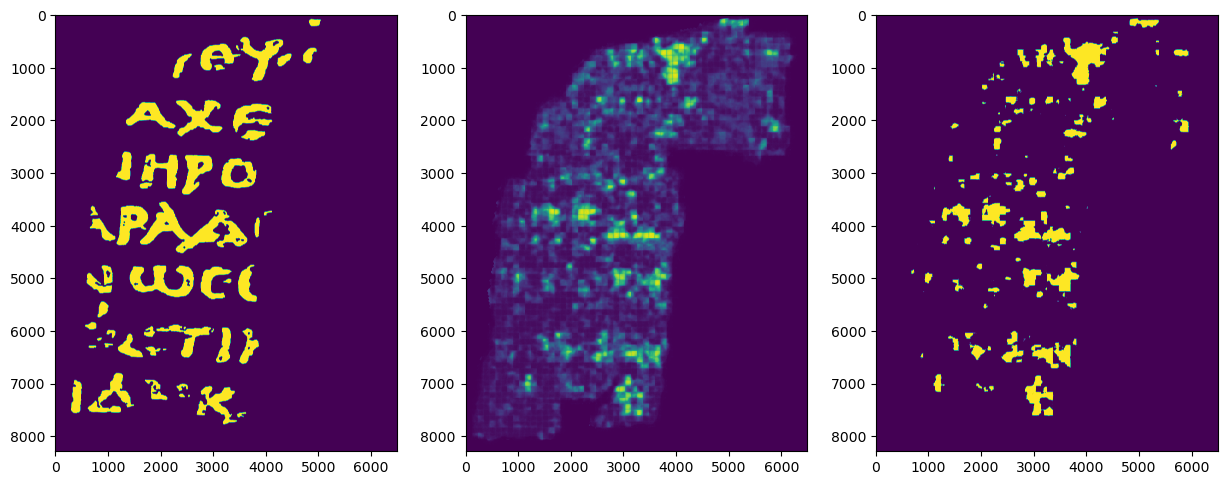

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([3.2682297e+07, 7.5182680e+06, 4.5697320e+06, 2.8256420e+06,
        1.5047040e+06, 9.1484700e+05, 6.8028500e+05, 5.5148400e+05,
        4.4663500e+05, 3.6447300e+05, 2.9905300e+05, 2.5691100e+05,
        2.2302700e+05, 1.9972300e+05, 2.0274000e+05, 1.8676800e+05,
        1.7077800e+05, 1.3204700e+05, 9.5711000e+04, 1.3723000e+04]),
 array([1.56840485e-07, 4.48484808e-02, 8.96968048e-02, 1.34545129e-01,
        1.79393453e-01, 2.24241777e-01, 2.69090101e-01, 3.13938425e-01,
        3.58786749e-01, 4.03635073e-01, 4.48483397e-01, 4.93331720e-01,
        5.38180044e-01, 5.83028368e-01, 6.27876692e-01, 6.72725016e-01,
        7.17573340e-01, 7.62421664e-01, 8.07269988e-01, 8.52118312e-01,
        8.96966636e-01]),
 <BarContainer object of 20 artists>)

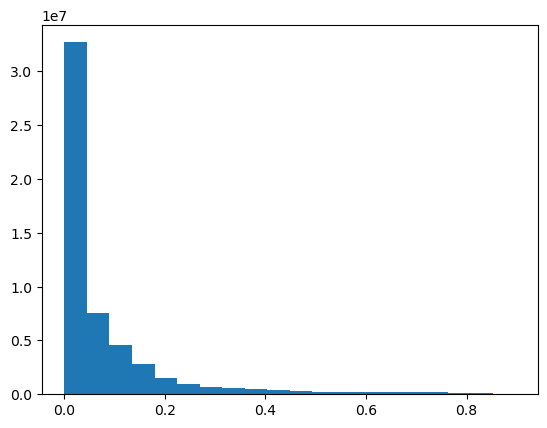

In [39]:
plt.hist(mask_pred.flatten(), bins=20)

In [40]:
# GPU VRAM 5.2GB/16.0GB A4000